## NLP with DL

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Import libraries

In [5]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GRU, Embedding, Dropout, BatchNormalization, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

Datasetimiz hepsiburada musterilerinin olumlu ve olumsuz yorumlarindan olusuyor : 

In [6]:
df = pd.read_csv('/content/drive/MyDrive/hepsiburada.csv')

In [8]:
df.head()

,Rating,Review
0,1,3 yıldır tık demedi. :)
1,1,3 yıldır kullanıyorum müthiş
2,1,Ürün bugün elime geçti çok fazla inceleme fırs...
3,1,Almaya karar verdim. Hemencecik geldi. Keyifle...
4,1,Günlük kullanımınızı çok çok iyi karsılıyor kı...


Datada hic NaN deger yok. (NLP modellerinde NaN deger oldugu zaman doldurulmaz, silinir.)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 243497 entries, 0 to 243496
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   Rating  243497 non-null  int64 
 1   Review  243497 non-null  object
dtypes: int64(1), object(1)
memory usage: 3.7+ MB


__Rating -->__ 1 : Olumlu yorumlar, 0 : Olumsuz yorumlar.

In [10]:
df.Rating.value_counts()

1    229821
0     13676
Name: Rating, dtype: int64

Ilgilenilen class hangisi ise onun class' i 1 olmasi gerekir. Biz olumsuz yorumlarla ilgilendigimiz icin 1 ve 0' in yerlerini degistirdik :

In [11]:
df.Rating = df.Rating.map({1:0, 0:1})

In [12]:
df.Rating.value_counts()

0    229821
1     13676
Name: Rating, dtype: int64

Class' larin bulunma yuzdesine bakmak icin asagidaki kodu yazdik. value_counts sadece series' lere uygulandigi icin array' i series' e cevirdik. Corpusta %95 olumlu yorum, %5 olumsuz yorum var. Asagidaki skorlara baktiktan sonra datasetimizin dengesiz olup olmadigina karar verecegiz :

In [13]:
pd.Series(df.Rating).value_counts(normalize=True)

0    0.943835
1    0.056165
Name: Rating, dtype: float64

## Tokenization

X ve y' nin sonuna 'values' koyarak array' e cevirdik. Hem DL modelleri array ile calisir hem de array' ler daha hizli calisir :

In [14]:
X = df['Review'].values
y = df['Rating'].values

__Tokenizer -->__ Tensorflow kutuphanesinin tokenizer islemlerini yapmak icin kullandigi fonksiyondur.

__Tokenizer Parametreleri__

__lower -->__ Kucuk harfe cevir. (Default=True)

__filters -->__ Datada temizlenmek istenen ozel karakterler buna yazilir. Sayilar cikarilmak isteniyorsa icerisine manuel olarak dahil edilebilir. (DL modellerinde temizlenmese de olur fakat bunlar datada noise yaptiklari icin temizlenmesi daha uygundur. DL modellerinde sadece noktalama isaretlerini temizlememiz ve kucuk harfe donusturmemiz yeterli olur. DL modellerinde, ML modellerinde oldugu gibi Stop word veya Lemmatization islemlerini yapmaya gerek yoktur.)

__num_words -->__ Egitime girecek token sayisina karar verir. Best practise olarak ozellikle classification islemlerinde corpusta en fazla gecen 10 bin, 15 bin kadar tokenin model egitimi icin yeterli oldugu gorulmus, istege gore daha fazlasi da alinabilir fakat bu da calisma maliyeti olarak geri doner. (Default=None --> Corpustaki tum tokenleri al)

In [15]:
num_words = 15000    # corpusta geçen en fazla kullanılan ilk 15.000 kelimeyi(tokeni) alacağız gerisini yok sayacağız. 
# None değeri atanırsa tüm kelimeler dikkate alınır.

Biz sayilarin kalmasini istedik cunku bazen musteriler puanlarla da yorumlama yapabilirler (10 numara gibi).

num_words' u 15000 olarak belirledik ve bir degiskene atadik. Tokenizer icindeki baska herhangi bir parametreyle oynamadan Tokenizer islemini tamamladik :

In [ ]:
tokenizer = Tokenizer(num_words=num_words) #filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n1234567890' 

__fit_on_texts -->__ _"Tokenization islemini X' e uygula"._ Icerisine X corpusunu array seklinde verdik. Tokenizer icinde olusturdugumuz sartlara gore corpusta en fazla gecen ilk 15000 tokeni ayirdi ve sadece bunlara tokenization islemi yapti. 

In [17]:
tokenizer.fit_on_texts(X)

## Creating word index

__tokenizer.word_index -->__ Dictionary icinde corpusta en fazla kullanilan tokenleri sirasiyla verir. En cok kullanilan token "cok" tokeniymis.

Modele girmeden once tokenler sayisal verilere donusur. Kuracagimiz modelde de asagidaki her token karsisindaki sayiya donusecek :

In [18]:
tokenizer.word_index

{'çok': 1,
 'bir': 2,
 've': 3,
 'ürün': 4,
 'bu': 5,
 'iyi': 6,
 'güzel': 7,
 'için': 8,
 'tavsiye': 9,
 'ederim': 10,
 'daha': 11,
 'ama': 12,
 'da': 13,
 'gayet': 14,
 'hızlı': 15,
 'teşekkürler': 16,
 'aldım': 17,
 'de': 18,
 'ürünü': 19,
 'gibi': 20,
 'yok': 21,
 'uygun': 22,
 'olarak': 23,
 'kaliteli': 24,
 'en': 25,
 '2': 26,
 'kargo': 27,
 'fiyat': 28,
 'elime': 29,
 'kadar': 30,
 'ile': 31,
 'göre': 32,
 'geldi': 33,
 'var': 34,
 'hepsiburada': 35,
 'ben': 36,
 'gerçekten': 37,
 '1': 38,
 'fiyata': 39,
 'gün': 40,
 'sonra': 41,
 'cok': 42,
 'kesinlikle': 43,
 'telefon': 44,
 'biraz': 45,
 'hiç': 46,
 'ulaştı': 47,
 'memnun': 48,
 'hem': 49,
 'değil': 50,
 'kullanışlı': 51,
 '3': 52,
 'mükemmel': 53,
 'oldu': 54,
 'kullanıyorum': 55,
 'önce': 56,
 'sipariş': 57,
 'tek': 58,
 'her': 59,
 'bence': 60,
 'harika': 61,
 'kalitesi': 62,
 'bi': 63,
 'ayrıca': 64,
 '5': 65,
 'teşekkür': 66,
 'fiyatı': 67,
 'olması': 68,
 'ne': 69,
 'herkese': 70,
 'bile': 71,
 'uzun': 72,
 'süper': 73,

Corpusta ne kadar token varsa hepsini siralar fakat egitime sadece belirlenen sayi kadarini (15000) alir :

In [19]:
len(tokenizer.word_index)

217983

## Converting tokens to numeric

Tokenlerimizi bir sequence' e (dizin) donusturecegiz. (Her bir token karsisinda denk gelen sayiya donusecek)

__texts_to_sequences(X) -->__ X' deki text' leri sequence' e donustur. 

In [20]:
X_num_tokens = tokenizer.texts_to_sequences(X)

X' in 105. indexinde asagidaki yorum var :

In [21]:
X[105]

'Logitech ürünlerinin geneli kalite olarak çok iyidir. Adedini tam saymadım ama 10 un üzerinde kendime akrabalarıma arkadaşlarıma almışımdır hepside memnunlar. İhtiyacı olan kaçırmasın başkada ürün aramasın derim.'

X' in 105. indexindeki yorumdaki tokenlerin hepsi sequence isleminden sonra sayisal verilere donustu. 

'cok' tokeni yukarida 1 sayisina karsilik geliyordu. Bu kelime gercek yorumda 6. sirada yer aliyor fakat sequence isleminden sonra 5. siraya gelmis. Demek ki burada corpusta en fazla gecen ilk 15000 token icinde olmayan bir kelime var yorumunu yapabiliriz :

In [22]:
print(X_num_tokens[105])

[1816, 5360, 131, 23, 1, 1849, 74, 12, 118, 1533, 297, 745, 3216, 13402, 6326, 5030, 2463, 113, 2534, 8858, 4, 143]


Tokenlerin hepsi farkli sayilardan olusuyor. Butun tokenler sabit bir sayiya esitlenmeden modele veremeyiz. Cunlu DL modelleri, ayni boyutta veriler ister. Tum tokenleri mantikli bir sayida sabitlememiz gerekir. 

In [23]:
len(X_num_tokens[105])

22

In [24]:
len(X_num_tokens[106])

18

In [26]:
len(X_num_tokens[6150])

88

__X_num_tokens__ sayisal verilere donusturulmus tokenlerimizin oldugu degisken. for dongusuyle bunun icindeki her bir yorumu aldik ve list compherension icinde her seferinde yorumlari saydirdik. Bu sekilde corpus icindeki yorumlarin her birinin kac tokenden olustugunu saydirmis olduk. Daha sonra bu degerlere 'sum', 'mean' gibi islemleri uygulayabilmek icin array'e cevirdik :

In [27]:
num_tokens = [len(tokens) for tokens in X_num_tokens]
num_tokens = np.array(num_tokens)

## Maximum number of tokens for all documents

Asagida her document' in kac tokenden olustugunu goruyoruz :

In [ ]:
num_tokens

Her corpustaki document' te ortalama olarak 21 token var :

In [28]:
num_tokens.mean()

21.36101060793357

Bir document' teki en fazla tokene sahip document, 298 tokenden olusuyor :

In [29]:
num_tokens.max()

298

argmax ile en uzun yoruma ait olan index' i cagirdik. 21941. index' teki yorum, en uzun yorummus (298 tokenli):

In [30]:
num_tokens.argmax() # listedeki en uzun yorumun indexini argmax ile bulabiliyoruz.

21941

En uzun yorum :

In [31]:
X[21941]

'Özellikle bu kısma yazıyorum iyice okuyunuz,cihazın hızı çok iyi.Isınma normal boyutlarda.Kamerası elinizi sabit tutarsanız ve gündüz çok net gece ise çok net çekmez.Görüntülü konuşma özelliği yok ancak uygulama ile olur,anten çekimi gayet iyi.Parmak izi okuyucusu gayet hızlı bazen tuşu silmenizi istiyor ve okuyamıyor kirden vs...Ön kamera da tatmin edici,çekim esnasında ekran beyaz ışık vererek flaş görevi görür.Batarya bana 1 hafta gidiyor sık kullanımda ise 2-3 gün gidiyor.Hızlı şarj 1 saatte doluyor , şekilleri ele oturuyor ve şık bir görüntü var.Telefonu aldığım gün gittim ve ilk girdiğim yerden ekran koruyucu ve kılıf buldum.Kulaklık sesi çok net ve yüksek ancak kendi hoparlörü biraz zayıf sesi.Ekrana bakarken açık kalma özelliği yok.Diğer akıllı cihaz özellikleri %90 ı bu cihazda mevcut.Güç tasarrufu 2 ayrı modu var ve çok başarılı çalışıyor.4gb ram var genelde yarısı boş kalıyor.Bir de yeni cihazların çoğu titreşimi az ve sesi de az çıkıyor.Bu cihaz da içine dahil...Bu cihazla

Her document' te bulunan yorumlarin ortalamasi 21 idi. Bu sayiyi en uzun sayi olan 298' e sabitlemek islem maliyetini cok artirir. 

In [34]:
len(X_num_tokens[21941])

298

Her document' ten alacagimiz sabit token sayisini nasil hesaplamamiz gerektigini gormek icin asagida bir ornek yapalim :

Bir liste icerisine tokenleri temsilen sayilar yazdik. Bu listeyi array' e cevirerek 10' dan kucuk olanlari cagirdik, kucuk olan degerleri False, buyuk olan degerleri ise True döndürdü. 

Bir sonraki adimda bu islemi sum icine yazdik, True' lari 1 sayarak topladi, False' lari da 0 sayarak topladi ve 3 buldu. Yani listede 10' dan kucuk olan 3 sayi varmis.

Son adimda 10' dan kucuk olanlarin sayisini (yani 3), listedeki tum elemanlarin sayisina bolduk ve 0.5 degerini bulduk. Buradan su yorumu yapabiliriz : Model icin almak istedigimiz token sayisini 10' a sabitlersek yorumlarimizin %50' sinde herhangi bir bilgi kaybi olmayacak. 

5, 8, 9 yorumlarinda herhangi bir kayip olmayacak; 10' da 1 token kaybi, 12' de 3 token kaybi, 15' de 6 token kaybi olacak.

In [37]:
list = [5, 10, 8, 9, 12, 15]
print(np.array(list) < 10)
print(sum(np.array(list) < 10))
print(sum(np.array(list) < 10)/len(list))

[ True False  True  True False False]
3
0.5


Deneme-yanilma yoluyla corpusumuzdaki her yorumda olmasi gereken token sayisini 61' e sabitledik :

In [38]:
max_tokens = 61

Her yorum icin 61 token sectigimizde yorumlarimizin %95' inde herhangi bir bilgi kaybi olmayacak (En az %95 degerini alacak sekilde bir deger secebilebilir. Token sayisi arttikca islem gucu de artacaktir. Bu yuzden hedef, en az token sayisi ile en fazla bilgiye ulasmaktir) :

In [39]:
sum(num_tokens < max_tokens) / len(num_tokens)

0.9598968365113328

In [40]:
sum(num_tokens < max_tokens)

233732

Corpustaki 243497 yorumdan 233732 tanesi, 61 tokenden daha kucuk. Yani 233732 tane yorumda hicbir bilgi kaybi olmayacak.

In [41]:
len(num_tokens)

243497

## Fixing token counts of all documents (pad_sequences)

Yukarida token sayisini 61' de sabitlemeye karar verdik. Bunun icin __pad_sequences__ fonksiyonunu kullanacagiz.

__pad_sequences -->__ Icerisine X datasinin numeric degerleri verilir. __maxlen__ parametresine de tum document' ler kac tokene sabitlenmek isteniyorsa o sayi verilir. 

In [42]:
X_pad = pad_sequences(X_num_tokens, maxlen=max_tokens)

Butun document' lerdeki token sayisi 61' e sabitlendi :

In [43]:
X_pad.shape

(243497, 61)

pad_sequences' in yaptigi islemi anlayabilmek icin X_num_tokens' ten bir ornek sectik (800. index). (Daha okunakli olmasi icin array'e cevirdik). 

In [44]:
np.array(X_num_tokens[800])

array([  19,  341,   52,  194,   30,   54, 7992,   55,  209,  603, 7887,
          3,   36,  114,  164,  479,   85,    1, 1682,  782,   30,    2,
        380,  326,    3,    1,   81,  132,  562,    9,   10])

X_num_tokens' teki 800. yorumda 31 token var, token sayilari 61'e sabitlenince pad_sequences, olmayan tokenler yerine 0 degerini atayarak padding islemi yapti :

In [45]:
X_pad[800]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,   19,  341,   52,
        194,   30,   54, 7992,   55,  209,  603, 7887,    3,   36,  114,
        164,  479,   85,    1, 1682,  782,   30,    2,  380,  326,    3,
          1,   81,  132,  562,    9,   10], dtype=int32)

21941. indexteki yorum ise 61 tokenden cok daha fazla tokene sahip :

In [46]:
np.array(X_num_tokens[21941])

array([  145,     5,  5876,  2225,  1653,   902,   203,     1,     6,
        2958,   163,  4248,   374,  3449,  1521, 12582,     3,  1381,
           1,   491,   281,   140,     1,   491,  3391,  2388,   235,
          21,    82,   756,    31,   212,  4458,  1448,    14,     6,
         472,   609,  2159,    14,    15,   673,  1681,  2152,     3,
         313,   444,   261,    13,   561,   463,   470,  1664,   168,
         639,   519,  3209,  5455,  6409,   600,   625,   153,    38,
         194,   272,   635,   389,   140,    26,    52,    40,   272,
          15,    84,    38,   466,  1679, 12350,  1036,   999,     3,
          96,     2,   318,    34,   134,   169,    40,  2752,     3,
          77,   750,   168,   881,     3,   509,   571,   359,   195,
           1,   491,     3,   172,    82,   256,  6460,    45,   926,
         195,  2061,  6575,   603,  7031,   235,    21,   103,   931,
         136,   394,  1316,  1917,     5,  2167,   567,  1034,  2217,
          26,   335,

61 tokenden fazla tokene sahip yorumlarda ise son 61 token alinir. Asil fikirler genel olarak sonda soylendigi icin default degeri, sondaki tokenleri almak olarak belirlenmis :

In [47]:
X_pad[21941]

array([ 872, 3501,  537, 1804,  488, 2218,   75,  163,    2,  456,   13,
       1308, 1865, 3432,    5,  824, 7798,  836, 1640, 7838, 3344,   12,
       1308,   31, 3063,  299, 2704,  851, 1052,   39, 1490, 3436,  317,
       1170,   75,  537,   50,  327,  246, 1322,  120,    2, 3436, 7527,
        199,  260,  579, 6176, 1800,   13,   45,  808,  108,    3,  865,
        749, 5840,   50,  106,   76,  879], dtype=int32)

## Train Test Split

Token sayilarini sabitleme islemini yaptigimiz icin artik train-test split islemine gecip modelimizi kurabiliriz. 

In [48]:
from sklearn.model_selection import train_test_split

Train-test split islemini ML modellerindeki ayni mantikla kuruyoruz. RNN modellerinde oldugu gibi ozel bir islem yapmamiza gerek yok. Cunku yorumlarin kendi iclerindeki sira onemli, yorumlarin kendi aralarindaki siralarinin degismesinin bir onemi yok. 

X_train olarak X_pad' i verdik. (X_pad icinde token sayilari 61' e sabitlendi.)

Sayisal olarak dengesiz bir datasetimiz oldugu icin _stratify=y_ belirttik (Dengeli datasetlerinde kullanilmasinin bir sakincasi yok) :

In [49]:
X_train, X_test, y_train, y_test = train_test_split(X_pad, y, test_size=0.2, stratify=y, random_state=0)

## Modelling

In [50]:
model = Sequential()

Yukarida tokenlerin hepsi birer sayisal degere cevrilmisti. Modele verebilmek icin bu sayisal degerlerin hepsini birer __word embedding__ e donusturmemiz gerekir. Bu degerlerin hepsinin kac boyutlu vektorler olmasi gerektigini belirtmemiz gerekir (Her bir token sayisal olarak kac feature ile temsil edilsin?). 

__embedding_size__ degeri olarak, best practise' te 50, 100, 200, 300 sayilari tercih edilir. Bu parametre __underfitting__ ve __overfitting__ i onlemede kullanilan bir parametre oldugu icin secimi onemlidir. NLP modellerinde inbalance datalar overfitting' e cok yatkindir. Bu yuzden bu tarz datalarda overfitting ile mucadele ederken bu parametre ile oynanabilir. 

Deneme-yanilma yoluyla embedding_size boyutunu belirledik (Kucuk bir corpusumuz oldugu icin boyutu cok fazla buyutmeye gerek yok) :

In [51]:
embedding_size = 50

In [ ]:
# pip install -U numpy==1.19.5

__Embedding layer__ sadece NLP modellerinde kullanilan bir layer' dir. LSTM ve GRU layer' larindan once bu layer tanimlanir. 

Egitime girecek olan 15000 __(input_dim)__ yorum var ve bu yorumlarin hepsi 61 __(max_tokens)__ token uzunlugunda ve her bir token de 50 __(output_dim)__ boyutlu word embedding' lerden olusuyor. 

__Embedding__ islemi ile 3 boyutlu matrisler olusturuyoruz. Bu bilgileri belirtmeden model kuramayiz. 

GRU modeli sectik fakat LSTM model de denenip en iyi skoru veren model tercih edilebilir. 

Best practise olarak NLP' de RNN modelleri kurarken en fazla 5 layerdan olusan GRU veya LSTM modelleri kurulmasi tavsiye edilir. Biz modelimizde 2 layer kullandik. Daha fazla layer kullandigimizda model overfit oldu. 

Model overfite gittigi icin __Dropout__ kullandik. %20 dropout ile 50 boyutlu vektorun en fazla %20' si kapatilir. (max %20' si kapatilir, daha az da olabilir, her epoch'ta bu sayi max %20 olacak sekilde degisir). Dropout degeri ve yeri degistirilerek farkli varyasyonlar denenerek overfitin onune gecilebilir.

__units=48 -->__ Timeseries modellerinde 'units', nöron sayisini temsil ediyordu. Burada ise embedding_size' i temsil eder. Yukarida vektorumuzun boyutunu 50 olarak belirlemistik, burada bu sayiyi 48' e dusurduk. (Bu sayi istege gore degistirilebilir. Ayni boyutla baslayip yariya dusurulebilir.)

__return_sequences=True -->__ Her t aninda her yeni token modele geldigi zaman yeni bir hidden state olusur. Hatirlanmasi gereken bilgiler cell state' e aktarilirken hidden state' e yeni token gelir. Her asamanin sonunda hidden state ve cell state birbirine esitlenir. cell state' te cok fazla bilgi birikirse LSTM ve GRU modellerde bile belli bir uzunluktan sonra unutmalar baslayabilir. _return_sequences_, cell state' te meydana gelebilecek unutmalarin olmamasi icin bunlarin topluca sonraki layer' a aktarilmasini saglar. GRU ve LSTM' den sonra tekrar bir GRU ve LSTM layer' i kullanilacaksa bu parametreyi kullanmak zorunludur. 

LSTM ve GRU modelleri Exploding Gradient ve Vanishing Gradienti engelledigi icin __BatchNormalization__ kullanmaya gerek yok fakat tercihe gore kullanilabilir. 

In [52]:
model.add(Embedding(input_dim=num_words,
                    output_dim=embedding_size,
                    input_length=max_tokens))

model.add(Dropout(0.2))

model.add(GRU(units=48, return_sequences=True))
model.add(Dropout(0.2))

#model.add(GRU(units=24, return_sequences=True))
#model.add(Dropout(0.2))

model.add(GRU(units=12))

model.add(Dense(1, activation='sigmoid'))

In [53]:
optimizer = Adam(learning_rate=0.01)

__binary_crossentropy -->__ Binary class' larimiz oldugu icin bunu sectik. Bu degerin 0' a yakin olmasini isteriz. 

In [54]:
model.compile(loss='binary_crossentropy',
              optimizer=optimizer,
              metrics=['Recall'])

https://stats.stackexchange.com/questions/328926/how-many-parameters-are-in-a-gated-recurrent-unit-gru-recurrent-neural-network

__(None, 61, 50) -->__ None : batchsize (Henuz belirlemedigimiz icin None, asagida belirleyecegiz). Word embedding 61 tokenden olusuyor ve her bir token de 50 boyutlu :

In [55]:
model.summary() 
# 3 x (n2 + nm + 2n) m= input, n= output           # GRU' da RNN'e gore 3 kat fazla parametre.
# (48*48 + 100*48 +2*48)*3 ==> m = 50, n = 48
# (24*24 + 48*24  +2*24)*3 ==> m =  48, n = 24
# (12*12 + 24*12  +2*12)*3 ==> m =  24, n = 12

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 61, 50)            750000    
                                                                 
 dropout (Dropout)           (None, 61, 50)            0         
                                                                 
 gru (GRU)                   (None, 61, 48)            14400     
                                                                 
 dropout_1 (Dropout)         (None, 61, 48)            0         
                                                                 
 gru_1 (GRU)                 (None, 12)                2232      
                                                                 
 dense (Dense)               (None, 1)                 13        
                                                                 
Total params: 766,645
Trainable params: 766,645
Non-trai

__mode="auto" -->__ monitor artma egiliminde ise bunun buyumesi gereken bir sayi oldugunu tespit eder, azalma egiliminde ise azalmasi gereken bir sayi oldugunu tespit eder ve min degeri aramasi gerektigini dusunur. Modelimizde recall degerleri once yuksek cikip sonra azalmaya basliyor. Halbuki biz val_los' un max olmasini istiyoruz. Bu yuzden bu parametreyi __max__ olarak degistirdik. recall ve precision skorlari icin bu deger max yapilmalidir. NLP modellerinde ilk epoch' larda overfit tehlikesi fazla oldugu icin bu parametreyi dogru secmek onemlidir. 

__patience = 2 -->__ NLP modelleri cok cabuk overfit oldugu icin patience sayisini kucuk tercih ettik. 

__restore_best_weights=True -->__ Patience kac ise o skorlar icindeki en iyi skoru al.

In [57]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor="val_recall", mode="max", 
                           verbose=1, patience = 1, restore_best_weights=True)

Class' lar arasinda dengesizlik olabilecegini öngördügümüz icin __class_weight'__ i import ettik. class_weight ile az olan class' in agirligini artirdik :

In [66]:
from sklearn.utils import class_weight
classes_weights = class_weight.compute_sample_weight(class_weight='balanced', y=y_train)
pd.Series(classes_weights).unique()

array([0.52975426, 8.90215702])

https://keras.io/getting_started/faq/#why-is-my-training-loss-much-higher-than-my-testing-loss

Eger model overfite gidiyorsa batch_size kademeli olarak artirilip skorlar takip edilebilir. 

In [ ]:
model.fit(X_train, y_train, epochs=10, batch_size=256, sample_weight= classes_weights,
         validation_data=(X_test, y_test), callbacks=[early_stop])

Epoch 1/10
761/761 [==============================] - 135s 171ms/step - loss: 0.3209 - recall: 0.8592 - val_loss: 0.3223 - val_recall: 0.9280
Epoch 2/10
761/761 [==============================] - 130s 170ms/step - loss: 0.1973 - recall: 0.9284 - val_loss: 0.1818 - val_recall: 0.8325
Epoch 2: early stopping


__loss -->__ loss degeri tahminimizin ne kadar guclu oldugunu gosterir. Diyelim ki corpustaki ilk yorum olumlu olsun ve model bunu %99 oraninda bilmis olsun. Bu degerinin log' u alindiginda log(99), 0' a cok yakin bir deger bulunur. Bu yuzden bu degerin 0' a yakin olmasi modelin basarisinin yuksek oldugunu gosterir.

__!!!__ Dengesiz datasetlerinde sayisi fazla olan class yuksek skorlarla tahmin edilirken sayisi az olan class dusuk skorlarla tahmin edilse bile epoch sonunda loss degerlerinin ortalamasi alinirken dusuk skorlu class' in sayisi az oldugu icin ortalamaya cok fazla etki etmez ve loss degeri 0' a yakin cikar. Halbuki sayisi az olan class' lar cok kotu tahmin edilmistir. Bu yuzden  NLP' de (ozellikle dengesiz datasetlerinde) loss degeri ML' deki accuracy degeri ile esdegerdir. Bu nedenle model calistirildiktan sonra train ve test set skorlarinin mutlaka kontrol edilmesi gerekir.  __!!!__

NLP' de genel olarak 1 veya 2 epoch kullanilir. 

NLP' de genelde ilk epoch' larda loss degeri val_loss degerinden buyuk olur. Cunku data ilk epoch' ta egitim asamasindadir. Ilerleyen epoch' larda ogrenme artcagi icin loss ve val_loss degerleri birbirine yaklasacaktir. Epoch sayisi az oldugunda ise __model.history.history__ grafigine bakarak overfitting var veya yok kararini veremeyiz. ML modellerinde oldugu gibi train ve test skorlarini mutlaka karsilastirmamiz gerekir.

## Model evaluation

In [ ]:
model_loss = pd.DataFrame(model.history.history)
model_loss.head()

,loss,recall,val_loss,val_recall
0,0.320903,0.859245,0.322289,0.927971
1,0.197325,0.928434,0.181824,0.832541


Model toplamda 2 epoch calisti ve __restore_best_weights=True__ parametresinden dolayi ilk epoch skorunu aldi. Grafige bakarak model hakkinda yorum yapmak pek saglikli degil, train ve test skorlarina bakacagiz :

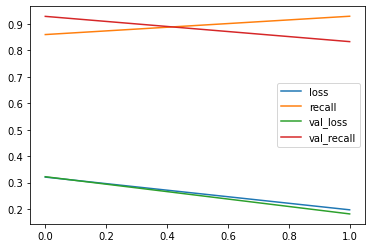

In [ ]:
model_loss.plot()

Train seti icin takip ettigimiz degerler olan val_loss ve val_recall degerlerini model.evaluate ile yazdirdik :

In [ ]:
model.evaluate(X_train, y_train)

6088/6088 [==============================] - 85s 14ms/step - loss: 0.2940 - recall: 0.9679


[0.2940090596675873, 0.9679188132286072]

Test seti icin aldigimiz loss ve recall degerleri asagida. Train set skorlari ile bunlari kiyaslayabiliriz veya bunun yerine asagidaki gibi train ve test set skorlarini __confusion_matrix__ ile de kiyaslayabiliriz :

In [ ]:
model.evaluate(X_test, y_test)

1522/1522 [==============================] - 22s 14ms/step - loss: 0.3223 - recall: 0.9280


[0.3222893178462982, 0.9279707670211792]

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score, roc_auc_score
y_train_pred = model.predict(X_train) >= 0.5

print(confusion_matrix(y_train, y_train_pred))
print("-------------------------------------------------------")
print(classification_report(y_train, y_train_pred))

[[160497  23359]
 [   351  10590]]
-------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.87      0.93    183856
           1       0.31      0.97      0.47     10941

    accuracy                           0.88    194797
   macro avg       0.65      0.92      0.70    194797
weighted avg       0.96      0.88      0.91    194797



Modelde herhangi bir overfit durumu gorulmuyor, train ve test set skorlari birbirine yakin. Bizim icin onemli olan 1 class' inin train ve test set skorlarina baktigimizda recall skorlari cok yuksek cikmis fakat precision skorlari oldukca dusuk (Model cok fazla tahmin yapiyor).

In [ ]:
y_pred = model.predict(X_test) >= 0.5

print(confusion_matrix(y_test, y_pred))
print("-------------------------------------------------------")
print(classification_report(y_test, y_pred))

[[39583  6382]
 [  197  2538]]
-------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.86      0.92     45965
           1       0.28      0.93      0.44      2735

    accuracy                           0.86     48700
   macro avg       0.64      0.89      0.68     48700
weighted avg       0.96      0.86      0.90     48700



Dengesiz bir datasetimiz oldugu icin modelin genel performansina bakmak icin precision_recall_curve grafigini cizdirdik. Modelin basarisi %73 :

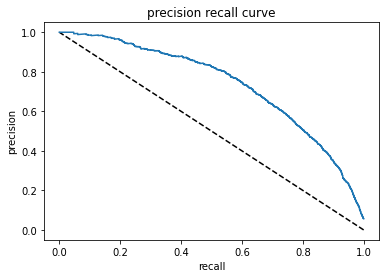

In [ ]:
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt

y_pred_proba = model.predict(X_test)
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba,)
plt.plot([1,0],[0,1],'k--')
plt.plot(recall, precision)
plt.xlabel('recall')
plt.ylabel('precision')
plt.title('precision recall curve')
plt.show()

In [ ]:
average_precision_score(y_test, y_pred_proba)

0.7356418283772912

## Scores without sample_weight

sample_weight kullanmadan aldigimiz skorlarda train ve test seti arasinda oldukca fark var. Model, overfit olmus :

In [ ]:
y_train_pred = model.predict(X_train) >= 0.5

print(confusion_matrix(y_train, y_train_pred))
print("-------------------------------------------------------")
print(classification_report(y_train, y_train_pred))

[[182573   1283]
 [  2146   8795]]
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.99      0.99      0.99    183856
           1       0.87      0.80      0.84     10941

    accuracy                           0.98    194797
   macro avg       0.93      0.90      0.91    194797
weighted avg       0.98      0.98      0.98    194797



In [ ]:
y_pred = model.predict(X_test) >= 0.5

print(confusion_matrix(y_test, y_pred))
print("-------------------------------------------------------")
print(classification_report(y_test, y_pred))

[[45310   655]
 [ 1015  1720]]
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.98      0.99      0.98     45965
           1       0.72      0.63      0.67      2735

    accuracy                           0.97     48700
   macro avg       0.85      0.81      0.83     48700
weighted avg       0.96      0.97      0.96     48700



## Base model without sample weights


model.add(Embedding(input_dim=num_words,
                    output_dim=embedding_size,
                    input_length=max_tokens))

model.add(Dropout(0.5))

model.add(GRU(units=48, return_sequences=True))

model.add(Dropout(0.5))

model.add(GRU(units=12))

model.add(Dense(1, activation='sigmoid'))


optimizer = Adam(learning_rate=0.001)


model.compile(loss='binary_crossentropy',
              optimizer=optimizer,
              metrics=['Recall'])


model.fit(X_train, y_train, epochs=1, batch_size=128,
         validation_data=(X_test, y_test))

class_weight yapmadan sadece parametreler ile oynayarak aldigimiz skorlar asagida, overfit bu sekilde de engellenmis. Musteri icin recall degeri onemli ise yukaridaki class_weight ile kurdugumuz model sunulabilir. 

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score, roc_auc_score
y_train_pred = model.predict(X_train) >= 0.5

print(confusion_matrix(y_train, y_train_pred))
print("-------------------------------------------------------")
print(classification_report(y_train, y_train_pred))

[[182868    988]
 [  4445   6496]]
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.98      0.99      0.99    183856
           1       0.87      0.59      0.71     10941

    accuracy                           0.97    194797
   macro avg       0.92      0.79      0.85    194797
weighted avg       0.97      0.97      0.97    194797



In [ ]:
y_pred = model.predict(X_test) >= 0.5

print(confusion_matrix(y_test, y_pred))
print("-------------------------------------------------------")
print(classification_report(y_test, y_pred))

[[45669   296]
 [ 1321  1414]]
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.97      0.99      0.98     45965
           1       0.83      0.52      0.64      2735

    accuracy                           0.97     48700
   macro avg       0.90      0.76      0.81     48700
weighted avg       0.96      0.97      0.96     48700



## Model Saving

In [ ]:
model.save('review_hepsiburada.h5')

## Loading Model

Yukarida modelimizi kaydettik. Modelimiz hangi nerede kayitli ise load_model ile ordan cagirdik :

In [ ]:
from tensorflow.keras.models import load_model
model_review = load_model('/content/drive/MyDrive/review_hepsiburada.h5')

## Predicton

Prediction icin sample' lar yazip modele verdik :

In [ ]:
review1 = "çok beğendim herkese tavsiye ederim"
review2 = "süper ürün aynı gün elime geçti"
review3 = "büyük bir hayal kırıklığı yaşadım bu ürünü bu markaya yakıştıramadım"
review4 = "kelimelerle tarif edilemez"
review5 = "tasarımı harika ancak kargo çok geç geldi ve ürün açılmıştı hayal kırıklığı gerçekten"
review6 = "hiç resimde gösterildiği gibi değil"
review7 = "kötü yorumlar gözümü korkutmuştu ancak hiçbir sorun yaşamadım teşekkürler"
review8 = "hiç bu kadar kötü bir satıcıya denk gelmemiştim ürün siparişimi iptal ediyorum"
review9 = "tam bir fiyat performans ürünü"
review10 = "beklediğim gibi çıkmadı"
review11 = "on numara beş yıldız"
review12 = "üründe sıkıntı var"
review13 = "televizyonun görüntü kalitesi çok kötü, dün akşam evde arkadaşlarla toplandık. yedik, içtik, sohbet ettik. Sonra televizyonda Türkiye - İngiltere maçını seyrettik. "
review14 = '1 gün gibi kısa bir sürede elime geçti. Ve bu fıyata süper bir ürün tavsiye ederim. Lakin eli büyük olan kişiler daha büyük modelini tercih edebilirler ortaboy ürün. Teşekkürler '
reviews = [review1, review2, review3, review4, review5, review6, review7, review8, review9, review10, review11, review12, review13, review14]

Bu yorumlari modele verebilmek icin oncelikle tokenizer islemine tabi tutarak tokenlerine ayirmamiz gerekir :

In [ ]:
tokens = tokenizer.texts_to_sequences(reviews)

pad_sequences ile tum yorumlari 61 tokene sabitledik :

In [ ]:
tokens_pad = pad_sequences(tokens, maxlen=max_tokens)
tokens_pad.shape

(14, 61)

0 : Olumlu yorum, 1 : Olumsuz yorum

Model, review7 haric butun yorumlari dogru olarak tahmin etti :

In [2]:
# model_review.predict(tokens_pad)   ---> 0.5' ten kucuk olanlar 0 classina, 0.5 yuksek olanlar 1 class' ina ait.

In [ ]:
(model_review.predict(tokens_pad) >0.5).astype("int")

array([[0],
       [0],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [0],
       [1],
       [0],
       [1],
       [1],
       [0]])